In [1]:
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from lifelines import CoxPHFitter
from sksurv.linear_model import CoxPHSurvivalAnalysis
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
from sksurv.ensemble import RandomSurvivalForest
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
from scipy.stats import chi2_contingency
from sklearn.calibration import calibration_curve
from matplotlib.font_manager import FontProperties
from sksurv.metrics import concordance_index_censored
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.metrics import integrated_brier_score
from sksurv.datasets import load_flchain
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from sksurv.util import Surv
from sklearn.metrics import roc_curve
plt.rcParams['font.sans-serif']=['Times New Roman']
pd.set_option('display.max_columns', None)

In [17]:
thresh_group = np.arange(0,0.7,0.01)
def calculate_net_benefit_model(thresh_group, y_pred_score, y_label):
    net_benefit_model = np.array([])
    tpr_list = []
    fpr_list = []
    for thresh in thresh_group:
        y_pred_label = y_pred_score > thresh
        
        tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
        n = len(y_label)
        net_benefit = (tp / n) - (fp / n) * (thresh / (1 - thresh))
        net_benefit_model = np.append(net_benefit_model, net_benefit)
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    print(tpr_list)  
    print(fpr_list) 
    return net_benefit_model

def calculate_net_benefit_all(thresh_group, y_label):
    net_benefit_all = np.array([])
    tn, fp, fn, tp = confusion_matrix(y_label, y_label).ravel()
    total = tp + tn
    for thresh in thresh_group:
        net_benefit = (tp / total) - (tn / total) * (thresh / (1 - thresh))
        net_benefit_all = np.append(net_benefit_all, net_benefit)
    return net_benefit_all

def plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all):
    #Plot
    ax.plot(thresh_group, net_benefit_model, color = 'crimson', label = 'Ref model')
    ax.plot(thresh_group, net_benefit_all, color = 'black',label = 'Treat all')
    ax.plot((0, 1), (0, 0), color = 'black', linestyle = ':', label = 'Treat none')

    #Fill，显示出模型较于treat all和treat none好的部分
    y2 = np.maximum(net_benefit_all, 0)
    y1 = np.maximum(net_benefit_model, y2)
    ax.fill_between(thresh_group, y1, y2, color = 'crimson', alpha = 0.2)

    #Figure Configuration， 美化一下细节
    ax.set_xlim(0,1)
    ax.set_ylim(net_benefit_model.min() - 0.15, net_benefit_model.max() + 0.15)#adjustify the y axis limitation
    ax.set_xlabel(
        xlabel = 'Threshold Probability', 
        fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax.set_ylabel(
        ylabel = 'Net Benefit', 
        fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax.grid('major')
    ax.spines['right'].set_color((0.8, 0.8, 0.8))
    ax.spines['top'].set_color((0.8, 0.8, 0.8))
    ax.legend(loc = 'upper right')

    return ax

# 合并文件

In [4]:
xlsx_path = glob.glob('*.xlsx')
combined_data = pd.DataFrame()
for file_path in xlsx_path:
    data = pd.read_excel(file_path)
    combined_data = pd.concat([combined_data, data], ignore_index=True)

# 处理缺失值

In [5]:
df = combined_data
df.isna().sum()

SEQN                                  0
RIDAGEYR（年龄）                          0
RIAGENDR（性别）                          0
RIDRETH1（种族）                          0
BMXWT（重量）                           115
BMXHT（站立高度）                         116
DPQ010                                0
DPQ020                                0
DPQ030                                0
DPQ040                                0
DPQ050                                0
DPQ060                                0
DPQ070                                0
DPQ080                                0
DPQ090                                0
降压治疗（0=没有；1=有；9=未记录）                  0
糖尿病（0=没有；1=有；9=未记录）                   0
降糖治疗（0=没有；1=有；9=未记录）                  0
降脂治疗（0=没有；1=有；9=未记录）                  0
LBDTCSI(总胆固醇mmol/L）                 479
TPA（1=积极；2=不积极；9=未记录）                 0
吸烟状况（1=当前吸烟；2=前吸烟者；3=不吸烟者；9=未记录）      0
饮酒状况（1=饮酒；2=不饮酒；9=未记录）                0
心血管相关疾病（0=没有；1=有；9=未记录）               0
MORTSTAT(最终死亡状况)                      6


In [6]:
# df[df['MORTSTAT(最终死亡状况)'].isnull()] 与MORTSTAT(最终死亡状况)同时丢失
df = df.dropna(subset=['MORTSTAT(最终死亡状况)'])

# 连续变量填中位数
median_values = df.median()
df = df.fillna(median_values)

# 判断类别

In [7]:
df['class'] = df['DPQ010']+df['DPQ020']+df['DPQ030']+df['DPQ040']+df['DPQ050']+df['DPQ060']+df['DPQ070']+df['DPQ080']+df['DPQ090']
conditions = [
    (df['class'].between(0,4)),
    (df['class'].between(5,9)),
    (df['class'].between(10,27))
]
values = ['none','mild','moderate']
df.loc[conditions[0], 'class'] = values[0]
df.loc[conditions[1], 'class'] = values[1]
df.loc[conditions[2], 'class'] = values[2]
# df.loc[conditions[3], 'class'] = values[3]

/tmp/ipykernel_3359985/3013131470.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'none' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[conditions[0], 'class'] = values[0]


In [8]:
df['class'].value_counts()

class
none        6666
mild        1567
moderate    1038
Name: count, dtype: int64

In [9]:
df = df.drop(df.columns[6:15], axis = 1)
df = df.iloc[:, 1:]

In [10]:
grouped = df.groupby('class')
dfs = {}
for group_name, group_df in grouped:
    dfs[group_name] = group_df.copy()
    dfs[group_name] = dfs[group_name].drop(dfs[group_name].columns[-1], axis=1)
none = dfs['none']
mild = dfs['mild']
mode = dfs['moderate']
# mode_se = dfs['Moderately Severe']
# se = dfs['Severe']

In [11]:
max(mode['PERMTH_INT[从NHANES面谈日期开始跟进（月份）]'])

159.0

# 卡方和

In [12]:
def p_and_chi2(surv1,surv2):
    data_new = pd.DataFrame({'a':surv1, 'b':surv2})
    bins = np.linspace(min(data_new['a'].min(), data_new['b'].min()), max(data_new['a'].max(), data_new['b'].max()), 10)
    data_new['a_binned'] = pd.cut(data_new['a'], bins, labels=False, include_lowest=True)
    data_new['b_binned'] = pd.cut(data_new['b'], bins, labels=False, include_lowest=True)
    contingency_table = pd.crosstab(data_new['a_binned'], data_new['b_binned'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p
    

# RSF

In [13]:
def process_data_rsf(df):
    E = df.iloc[:,14]
    T = df.iloc[:,15]
    SurvObj = np.array([(e, t) for e, t in zip(E, T)], dtype=[('E', np.bool_), ('T', np.float64)])
    X_train, X_test, y_train, y_test = train_test_split(df, SurvObj, test_size=0.3, random_state=10)
    X_train = X_train.iloc[:,:-2]
    X_test = X_test.iloc[:,:-2]
    rsf = RandomSurvivalForest(n_estimators=600,random_state=24)
    rsf.fit(X_train, y_train)
    # pred = rsf.predict(X_test)
    pred2 = rsf.predict_survival_function(X_test)
    probility_all = [] 
    for i in range(len(pred2)):
        probility_all.append(pred2[i].y)   
    probility_12 = []
    probility_36 = []
    probility_60 = []
    probility_96 = [] 
    for j in range(len(probility_all)):
        probility_12.append(probility_all[j][11])
        probility_36.append(probility_all[j][35])
        probility_60.append(probility_all[j][59])
        probility_96.append(probility_all[j][95])
    ccc = []
    
    for i in range(len(y_test)):
        if y_test[i][0]==False:
            ccc.append(0)
        if y_test[i][0]==True:
            ccc.append(1)
    ccc = np.array(ccc)
    probility_12_v2 = []
    for i2 in range(len(probility_96)):
        probility_12_v2.append(1-probility_96[i2])
    probility_12_v2 = np.array(probility_12_v2)
    
    net_benefit_model = calculate_net_benefit_model(thresh_group, probility_12_v2, ccc)
    net_benefit_all = calculate_net_benefit_all(thresh_group, ccc)
    
    return net_benefit_model,net_benefit_all, probility_12_v2, rsf

In [56]:
def process_data_rsf_high_low(df):
    E = df.iloc[:,14]
    T = df.iloc[:,15]
    SurvObj = np.array([(e, t) for e, t in zip(E, T)], dtype=[('E', np.bool_), ('T', np.float64)])
    X_train, X_test, y_train, y_test = train_test_split(df, SurvObj, test_size=0.3, random_state=10)
    rsf = RandomSurvivalForest(n_estimators=600,random_state=24)
    X_train = X_train.iloc[:,:-2]
    X_test = X_test.iloc[:,:-2]
    
    rsf.fit(X_train, y_train)
    risk_scores = rsf.predict(X_train)
    cutoff_value = np.percentile(risk_scores, q=90)
    high_risk_group = X_train[risk_scores > cutoff_value]
    low_risk_group = X_train[risk_scores <= cutoff_value]
    surv1 = rsf.predict_survival_function(low_risk_group, return_array=True)
    surv2 = rsf.predict_survival_function(high_risk_group, return_array=True)
    mean_surv1 = np.mean(surv1, axis=0)
    std_surv1 = np.std(surv1, axis=0)

    mean_surv2 = np.mean(surv2, axis=0)
    std_surv2 = np.std(surv2, axis=0)
    
    chi2,p = p_and_chi2(mean_surv1,mean_surv2)
    
    # 获取时间点
    times = rsf.unique_times_
    plt.figure(figsize=(6, 5))
    mpl.rcParams['font.family'] = 'Times New Roman'
    mpl.rcParams['font.size'] = 14 
    
    plt.step(times, mean_surv1, where="post", label="Low risk group",color="royalblue")
    plt.step(times, mean_surv2, where="post", label="High risk group",color="red")
    
    print(p)
    plt.text(10, 0.4, f"P:<0.001", ha='center')
    plt.text(30, 0.4, fr"$\chi^2$: {chi2:.2f}", ha='center')
    
    plt.grid(True,color='gray', linestyle='-', linewidth=0.5)
    plt.xlim(0, 96)
    plt.xticks([0, 16, 32, 48,64,80,96])
    plt.gca().set_facecolor('white')
    plt.xlabel('Time', fontsize=16, fontweight='bold')
    plt.ylabel('Survival Rate', fontsize=16, fontweight='bold')
    plt.legend(loc='lower left')
    
    plt.show()

1.580957161911652e-36


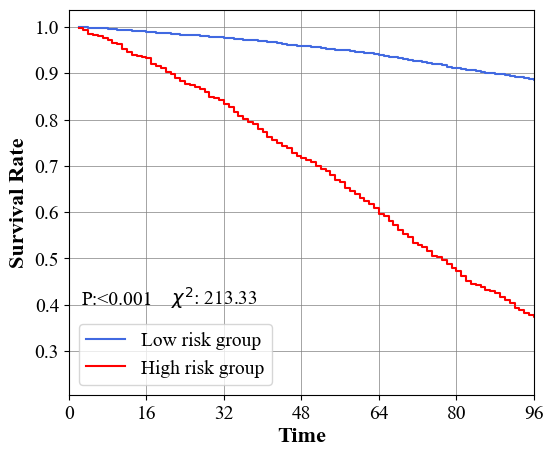

In [57]:
process_data_rsf_high_low(none)

# COX模型

In [13]:
def process_data_cox(df):
    train_data, test_data = train_test_split(df, test_size=0.3, random_state=10)
    cox = CoxPHFitter()
    cox.fit(train_data, duration_col='PERMTH_INT[从NHANES面谈日期开始跟进（月份）]', event_col='MORTSTAT(最终死亡状况)')
    pred2 = cox.predict_survival_function(test_data)
    probility = pred2.values.tolist()
    probility_v2 = probility[60]
    probility_v3 = []
    for i in range(len(probility_v2)):
        probility_v3.append(1-probility_v2[i])
    # print(len(train_data))
    # print(len(test_data))
    # print(len(probility_v3))
        
    net_benefit_model2 = calculate_net_benefit_model(thresh_group, probility_v3, test_data['MORTSTAT(最终死亡状况)'])
    net_benefit_all2 = calculate_net_benefit_all(thresh_group, test_data['MORTSTAT(最终死亡状况)'])
    
    return net_benefit_model2, net_benefit_all2, probility_v3

In [61]:
process_data_cox(none)

(array([0.19502786, 0.18552434, 0.17571752, 0.16803505, 0.16036219,
        0.15231123, 0.14588102, 0.13837   , 0.13341658, 0.1279704 ,
        0.12301757, 0.11768615, 0.11259401, 0.10721482, 0.10407301,
        0.09732483, 0.08914539, 0.08438383, 0.07953749, 0.0739603 ,
        0.0686348 , 0.06062168, 0.05536505, 0.05037269, 0.04582986,
        0.0394342 , 0.03662492, 0.03434052, 0.03213554, 0.026702  ,
        0.02250321, 0.01944688, 0.01625022, 0.0148518 , 0.01317071,
        0.00916614, 0.0084655 , 0.00751808, 0.00505372, 0.00437416,
        0.00385769, 0.00322564, 0.00335516, 0.00321099, 0.00270957,
        0.00226006, 0.00159547, 0.001573  , 0.00153319, 0.00151702,
        0.0012859 , 0.0012684 , 0.00125018, 0.00080255, 0.00103431,
        0.00080964, 0.00079882, 0.00057317, 0.0005613 , 0.00085727,
        0.00064295, 0.00064295, 0.00064295, 0.00042863, 0.00021432,
        0.00021432, 0.00021432, 0.00021432, 0.00021432, 0.00021432]),
 array([ 0.2       ,  0.19191919,  0.18367347,

# AUC

In [105]:
def test_a(df):
    train_data, test_data = train_test_split(df, test_size=0.3, random_state=10)
    cox = CoxPHFitter(penalizer=1000)
    cox.fit(train_data, duration_col='PERMTH_INT[从NHANES面谈日期开始跟进（月份）]', event_col='MORTSTAT(最终死亡状况)')
    predicted_partial_hazards = cox.predict_partial_hazard(test_data)
    E = test_data.iloc[:,14]
    T = test_data.iloc[:,15]
    times = max(test_data['PERMTH_INT[从NHANES面谈日期开始跟进（月份）]'])-1
    labels = (T <= times) & E
    auc = roc_auc_score(labels, predicted_partial_hazards.values)
    print(auc)

    event_at_time = test_data['MORTSTAT(最终死亡状况)']
    time_at_time = test_data['PERMTH_INT[从NHANES面谈日期开始跟进（月份）]']
    c_index = concordance_index(time_at_time, -(predicted_partial_hazards), event_at_time)
    print(f"C-index: {c_index:.4f}")
    
    survival_predictions = cox.predict_survival_function(test_data)
    times = survival_predictions.index.max()
    def calculate_BS(actual, predicted):
        return (predicted - actual)**2

    actual_survival = np.exp(-test_data['PERMTH_INT[从NHANES面谈日期开始跟进（月份）]'] / test_data['PERMTH_INT[从NHANES面谈日期开始跟进（月份）]'].mean())
    predicted_survival = survival_predictions.loc[times].mean()
    ibs = calculate_BS(actual_survival, predicted_survival)
    print("ibs:",ibs.mean())
    
    auc_values = []
    c_values = []
    ibs_values = []
    for _ in range(100):
        train_data, test_data = train_test_split(df, test_size=0.3)
        cox = CoxPHFitter()
        cox.fit(train_data, duration_col='PERMTH_INT[从NHANES面谈日期开始跟进（月份）]', event_col='MORTSTAT(最终死亡状况)')
        predicted_partial_hazards = cox.predict_partial_hazard(test_data)
        E = test_data.iloc[:,14]
        T = test_data.iloc[:,15]
        times = max(test_data['PERMTH_INT[从NHANES面谈日期开始跟进（月份）]'])-1
        labels = (T <= times) & E
        auc = roc_auc_score(labels, predicted_partial_hazards.values)
        auc_values.append(auc)
        event_at_time = test_data['MORTSTAT(最终死亡状况)']
        time_at_time = test_data['PERMTH_INT[从NHANES面谈日期开始跟进（月份）]']
        c_index = concordance_index(time_at_time, -(predicted_partial_hazards), event_at_time)
        c_values.append(c_index)
        
        survival_predictions = cox.predict_survival_function(test_data)
        times = survival_predictions.index.max()
        def calculate_BS(actual, predicted):
            return (predicted - actual)**2

        actual_survival = np.exp(-test_data['PERMTH_INT[从NHANES面谈日期开始跟进（月份）]'] / test_data['PERMTH_INT[从NHANES面谈日期开始跟进（月份）]'].mean())
        predicted_survival = survival_predictions.loc[times].mean()
        ibs = calculate_BS(actual_survival, predicted_survival)
        ibs_values.append(ibs.mean())
        
    lower_bound = np.percentile(auc_values, 2.5)
    upper_bound = np.percentile(auc_values, 97.5)
    print("auc95")
    print(f"{lower_bound} --- {upper_bound}")
    
    lower_bound = np.percentile(c_values, 2.5)
    upper_bound = np.percentile(c_values, 97.5)
    print("c95")
    print(f"{lower_bound} --- {upper_bound}")
    
    lower_bound = np.percentile(ibs_values, 2.5)
    upper_bound = np.percentile(ibs_values, 97.5)
    print("ibs")
    print(f"{lower_bound} --- {upper_bound}")
    
    return auc_values,c_values,ibs_values
auc_values,c_values,ibs_values = test_a(none)
auc_values1,c_values1,ibs_values1 = test_a(mild)
auc_values2,c_values2,ibs_values2 = test_a(mode)
# auc_values3,c_values3,ibs_values3 = test_a(mode_se)
# auc_values4,c_values4,ibs_values4 = test_a(se)

[0.7318868083670714, 0.7726231445935627, 0.762386415303211, 0.7741462617786643, 0.7944137495017799, 0.7962326903813906, 0.8017611870952756, 0.801440600980588, 0.800975204816286]
[0.5262312633832976, 0.6696312364425163, 0.7323809523809524, 0.7364037585421412, 0.7692227438706313, 0.7827521670606776, 0.8072552447552447, 0.8078834502008305, 0.7773879021239597]
[0.7986970684039087, 0.7608333333333334, 0.7677364864864865, 0.7495297805642633, 0.7528919860627178, 0.75390625, 0.748014440433213, 0.7317460317460318, 0.7428214731585518]


In [119]:
print(np.array(auc_values).mean())
print(np.array(auc_values1).mean())
print(np.array(auc_values2).mean())
print(np.array(ibs_values).mean())
print(np.array(ibs_values1).mean())
print(np.array(ibs_values2).mean())
print(np.array(c_values).mean())
print(np.array(c_values1).mean())
print(np.array(c_values2).mean())

0.8260936246561426
0.8052590466991123
0.7462381950392671
0.12368039952854265
0.11434704771387694
0.1162899244905963
0.7926927469407221
0.7675348234091826
0.7244571114195153


In [36]:
def cal_rsf_auc(df):
    E = df.iloc[:,14]
    T = df.iloc[:,15]
    SurvObj = np.array([(e, t) for e, t in zip(E, T)], dtype=[('E', np.bool_), ('T', np.float64)])
    X_train, X_test, y_train, y_test = train_test_split(df, SurvObj, test_size=0.3, random_state=10)
    times = max(X_test['PERMTH_INT[从NHANES面谈日期开始跟进（月份）]'])-1
    X_train = X_train.iloc[:,:-2]
    X_test = X_test.iloc[:,:-2]
    # rsf = RandomSurvivalForest(n_estimators=600,min_samples_leaf=250,n_jobs=-1)
    rsf = RandomSurvivalForest(n_jobs=-1,random_state=10, n_estimators=600)
    rsf.fit(X_train, y_train)
    pred = rsf.predict(X_test)
    
    # AUC
    auc = cumulative_dynamic_auc(y_train,y_test, pred, times=times-1)
    # C-index
    c_index = concordance_index_censored(y_test["E"], y_test["T"], pred)
    
    # iBS
    def calculate_BS(actual, predicted):
        return (predicted - actual)**2
    survival_predictions = rsf.predict_survival_function(X_test)
    # time_points = survival_predictions[0][0].x[0]
    
    
    survival_probs = [s.x for s in survival_predictions]
    fpr, tpr, thresholds = roc_curve(y_test["E"], survival_probs)
    # actual_survival = np.exp(-y_test['T'] / y_test['T'].mean())
    # sur_pred_list = []
    # for i in range(len(survival_predictions)):
    #       sur_pred_list.append(survival_predictions[i].y[-1])
    # ibs = calculate_BS(actual_survival, sur_pred_list)
    
    # print("ibs:",ibs.mean())
    # print("C-index:", c_index)
    # print("AUC:", auc)
    
    # auc_values = []
    # c_values = []
    # ibs_values = []
    # for _ in range(10):
    #     X_train, X_test, y_train, y_test = train_test_split(df, SurvObj, test_size=0.3)
    #     times = max(X_test['PERMTH_INT[从NHANES面谈日期开始跟进（月份）]'])-1
    #     X_train = X_train.iloc[:,:-2]
    #     X_test = X_test.iloc[:,:-2]
    #     rsf = RandomSurvivalForest(n_jobs=-1,random_state=10, n_estimators=300)
    #     rsf.fit(X_train, y_train)
    #     y_pred = rsf.predict(X_test)
        
    #     auc_boot = cumulative_dynamic_auc(y_train,y_test, y_pred, times=times-3)
    #     c_index = concordance_index_censored(y_test["E"], y_test["T"], y_pred)
         
    #     def calculate_BS(actual, predicted):
    #          return (predicted - actual)**2
    #     survival_predictions = rsf.predict_survival_function(X_test)
    #     sur_pred_list = []
    #     for i in range(len(survival_predictions)):
    #         sur_pred_list.append(survival_predictions[i].y[-1])
    #     actual_survival = np.exp(-y_test['T'] / y_test['T'].mean())
    #     ibs = calculate_BS(actual_survival, sur_pred_list)
        
    #     auc_values.append(auc_boot[0])
    #     c_values.append(c_index[0])
    #     ibs_values.append(ibs.mean())
        
    # auc_values = [x[0] for x in auc_values]
    # lower_bound = np.percentile(auc_values, 2.5)
    # upper_bound = np.percentile(auc_values, 97.5)
    # print("auc95")
    # print(f"{lower_bound} --- {upper_bound}")
    
    # print("c95")
    # lower_bound = np.percentile(c_values, 2.5)
    # upper_bound = np.percentile(c_values, 97.5)
    
    # print(f"{lower_bound} --- {upper_bound}")
    
    # lower_bound = np.percentile(ibs_values, 2.5)
    # upper_bound = np.percentile(ibs_values, 97.5)
    # print("ibs")
    # print(f"{lower_bound} --- {upper_bound}")
    
    # return auc_values,c_values,ibs_values

# auc_values5,c_values5,ibs_values5 = cal_rsf_auc(none)
# auc_values6,c_values6,ibs_values6 = cal_rsf_auc(mild)
auc_values7,c_values7,ibs_values7 = cal_rsf_auc(mode)
# auc_values8,c_values8,ibs_values8 = cal_rsf_auc(mode_se)
# auc_values9,c_values9,ibs_values9 = cal_rsf_auc(se)

ValueError: y should be a 1d array, got an array of shape (312, 141) instead.

In [245]:
a = np.array(ibs_values7)
a.mean()

0.1854527720552811

In [74]:
p_and_chi2(np.array(auc_values),np.array([x[0] for x in auc_values1]))

(3.6507936507936503, 0.4553231002975705)

# 画图

In [125]:
net_benefit_model,net_benefit_all, _,_ = process_data_rsf(mode)
net_benefit_model2, net_benefit_all2, _ = process_data_cox(mode)

In [123]:
def show_plot(net_benefit_model,net_benefit_model2, net_benefit_all, net_benefit_all2):
    fig, ax = plt.subplots()

    ax.plot(thresh_group, net_benefit_model, color = 'crimson', label = 'Rsf model')
    ax.plot(thresh_group, net_benefit_model2, color = 'royalblue', label = 'Cox model')
    ax.plot(thresh_group, net_benefit_all, color = 'black',label = 'Treat all')
    ax.plot((0, 1), (0, 0), color = 'black', linestyle = ':', label = 'Treat none')

    #Fill，显示出模型较于treat all和treat none好的部分
    y2 = np.maximum(net_benefit_all, 0)
    y1 = np.maximum(net_benefit_model, y2)
    y4 = np.maximum(net_benefit_all2, 0)
    y3 = np.maximum(net_benefit_model2, y2)
    ax.fill_between(thresh_group, y1, y2, color = 'crimson', alpha = 0.2)
    ax.fill_between(thresh_group, y3, y4, color = 'royalblue', alpha = 0.2)

    #Figure Configuration， 美化一下细节
    ax.set_xlim(0,0.7)
    ax.set_ylim(-0.20, net_benefit_model.max() + 0.15)#adjustify the y axis limitation
    ax.set_xlabel(
        xlabel = 'Threshold Probability', 
        fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax.set_ylabel(
        ylabel = 'Net Benefit', 
        fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax.grid('major')
    ax.spines['right'].set_color((0.8, 0.8, 0.8))
    ax.spines['top'].set_color((0.8, 0.8, 0.8))
    ax.legend(loc = 'upper right')
    #ax = plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all)
    fig.savefig('se_train.png', dpi = 300)
    plt.show()

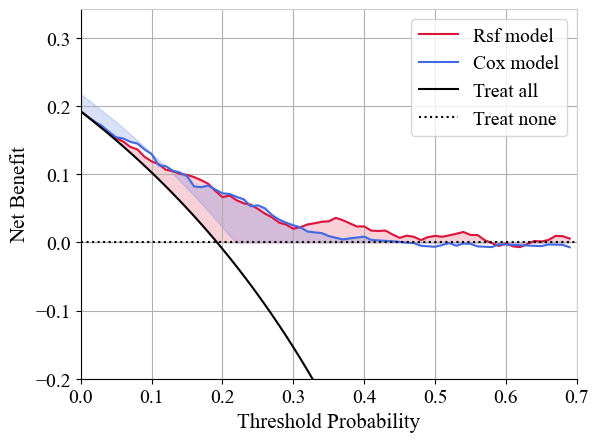

In [126]:
show_plot(net_benefit_model,net_benefit_model2, net_benefit_all, net_benefit_all2)

# jiaozheng

/tmp/ipykernel_3279139/1016003.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap(cmap)(float(i) / len(probas_list))
/tmp/ipykernel_3279139/1016003.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap(cmap)(float(j) / len(probas_list2))


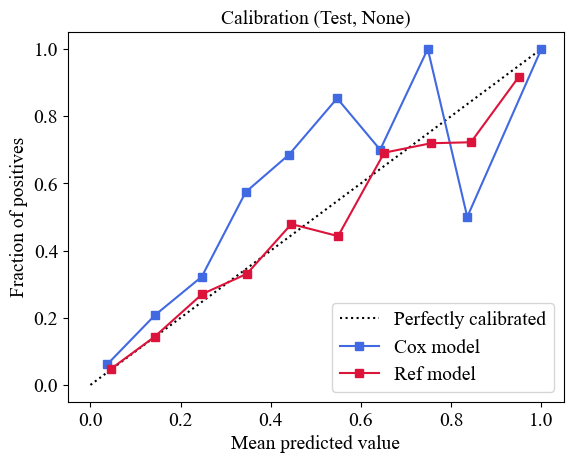

In [135]:
train_data, test_data = train_test_split(none, test_size=0.3, random_state=10)
y_true = test_data['MORTSTAT(最终死亡状况)']
y_true = np.asarray(y_true)
  
# if not isinstance(probas_list, list):
#     raise ValueError('`probas_list` does not contain a list.')
classes = np.unique(y_true)
if len(classes) > 2:
    raise ValueError('plot_calibration_curve only '
                        'works for binary classification')
_, _, probas_list = process_data_cox(none) 
_, _, probas_list2,_ = process_data_rsf(none) 
probas_list = [probas_list]
probas_list2 = [probas_list2]

clf_names = ['Cox model']
clf_names2 = ['Ref model']
if clf_names is None:
    clf_names = ['Classifier {}'.format(x+1)
                    for x in range(len(probas_list))]

if len(clf_names) != len(probas_list):
    raise ValueError('Length {} of `clf_names` does not match length {} of'
                        ' `probas_list`'.format(len(clf_names),
                                                len(probas_list)))
if clf_names2 is None:
    clf_names2 = ['Classifier {}'.format(x+1)
                    for x in range(len(probas_list))]

if len(clf_names2) != len(probas_list):
    raise ValueError('Length {} of `clf_names` does not match length {} of'
                        ' `probas_list`'.format(len(clf_names2),
                                                len(probas_list)))
ax=None
figsize=None
n_bins=10
cmap='nipy_spectral'
title_fontsize="large"
text_fontsize="medium"

if ax is None:
    fig, ax = plt.subplots(1, 1, figsize=figsize)

ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for i, probas in enumerate(probas_list):
    probas = np.asarray(probas)
    if probas.ndim > 2:
        raise ValueError('Index {} in probas_list has invalid '
                            'shape {}'.format(i, probas.shape))
    if probas.ndim == 2:
        probas = probas[:, 1]

    if probas.shape != y_true.shape:
        raise ValueError('Index {} in probas_list has invalid '
                            'shape {}'.format(i, probas.shape))

    probas = (probas - probas.min()) / (probas.max() - probas.min())

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_true, probas, n_bins=n_bins)

    color = plt.cm.get_cmap(cmap)(float(i) / len(probas_list))

    ax.plot(mean_predicted_value, fraction_of_positives, 's-',
            label=clf_names[i], color='royalblue')
    font_properties = FontProperties(family='Times New Roman')
    ax.legend(prop=font_properties)
    
for j, probas2 in enumerate(probas_list2):
    probas2 = np.asarray(probas2)
    if probas2.ndim > 2:
        raise ValueError('Index {} in probas_list has invalid '
                            'shape {}'.format(j, probas2.shape))
    if probas2.ndim == 2:
        probas2 = probas2[:, 1]

    if probas2.shape != y_true.shape:
        raise ValueError('Index {} in probas_list has invalid '
                            'shape {}'.format(j, probas2.shape))

    probas2 = (probas2 - probas2.min()) / (probas2.max() - probas2.min())

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_true, probas2, n_bins=n_bins)

    color = plt.cm.get_cmap(cmap)(float(j) / len(probas_list2))

    ax.plot(mean_predicted_value, fraction_of_positives, 's-',
            label=clf_names2[j], color='crimson')
    font_properties = FontProperties(family='Times New Roman')
    ax.legend(prop=font_properties)


title='Calibration (Test, None)'
ax.set_title(title, fontsize=text_fontsize,fontdict= {'family': 'Times New Roman'})

ax.set_xlabel('Mean predicted value', fontsize=text_fontsize,fontdict= {'family': 'Times New Roman'})
ax.set_ylabel('Fraction of positives', fontsize=text_fontsize,fontdict= {'family': 'Times New Roman'})

ax.set_ylim([-0.05, 1.05])
ax.legend(loc='lower right')

# Relative importance

In [14]:
df_for_importance = df.drop(df.columns[-1], axis=1)
_,_, _,model = process_data_rsf(df_for_importance)

In [15]:
from sklearn.inspection import permutation_importance

def relative_importance(df,model):
    E = df.iloc[:,14]
    T = df.iloc[:,15]
    SurvObj = np.array([(e, t) for e, t in zip(E, T)], dtype=[('E', np.bool_), ('T', np.float64)])
    X_train, X_test, y_train, y_test = train_test_split(df, SurvObj, test_size=0.3, random_state=10)
    X_train = X_train.iloc[:,:-2]
    X_test = X_test.iloc[:,:-2]
    result = permutation_importance(model, X_test, y_test, n_repeats=15, random_state=24)
    importance = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)
    return importance

In [16]:
importance = relative_importance(df_for_importance, model)

In [64]:
importance1.index

NameError: name 'importance1' is not defined

/tmp/ipykernel_3308480/463389984.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


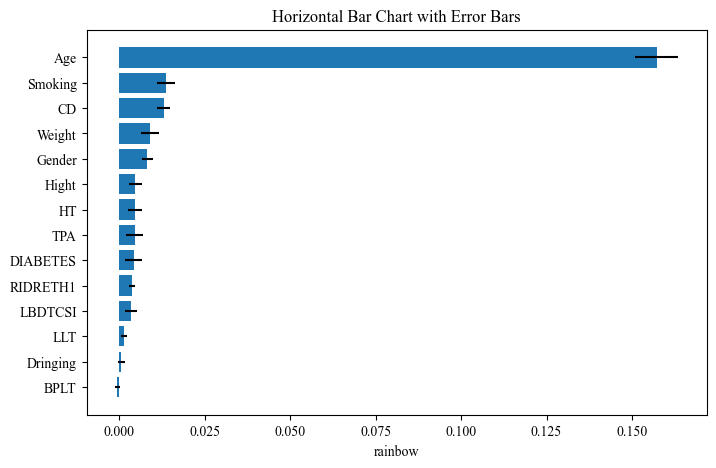

In [84]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

importance1 = importance.sort_values('importances_mean')

idx_list = ['BPLT', 'Dringing',
       'LLT', 'LBDTCSI', 'RIDRETH1',
       'DIABETES', 'TPA', 'HT',
       'Hight', 'Gender', 'Weight', 'CD',
       'Smoking', 'Age']

# norm = mcolors.Normalize(vmin=np.min(importance1['importances_mean']), vmax=np.max(importance1['importances_mean']))
# cmap = plt.cm.get_cmap('viridis')
# normalize = plt.Normalize(vmin=min(importance1['importances_mean']), vmax=max(importance1['importances_mean']))
# colors = cmap(normalize(importance1['importances_mean']))
# 创建条形图
plt.figure(figsize=(8,5))
plt.barh(idx_list, importance1['importances_mean'], xerr=importance1['importances_std'], capsize=0)

plt.xlabel('rainbow')
plt.title('Horizontal Bar Chart with Error Bars')

plt.show()


# ALL_AUC

In [31]:
rsf_none = [0.75946778, 0.79776985, 0.79149836, 0.81031622, 0.830801  ,
       0.83283708, 0.83062391, 0.82657836, 0.81946423]
rsf_mild = [0.48126338, 0.65488069, 0.73714286, 0.75562358, 0.78998435,
       0.79665364, 0.81720418, 0.84021116, 0.79920903]
rsf_mode = [0.80456026, 0.78611111, 0.78483953, 0.74326019, 0.74662021,
       0.7546875 , 0.74711261, 0.77147455, 0.77519897]
cox_none = [0.7318868083670714, 0.7726231445935627, 0.762386415303211, 0.7741462617786643, 0.7944137495017799, 0.7962326903813906, 0.8017611870952756, 0.801440600980588, 0.800975204816286]
cox_mild = [0.5262312633832976, 0.6696312364425163, 0.7323809523809524, 0.7364037585421412, 0.7692227438706313, 0.7827521670606776, 0.8072552447552447, 0.8078834502008305, 0.7773879021239597]
cox_mode = [0.7986970684039087, 0.7608333333333334, 0.7677364864864865, 0.7495297805642633, 0.7528919860627178, 0.75390625, 0.748014440433213, 0.7317460317460318, 0.7428214731585518]

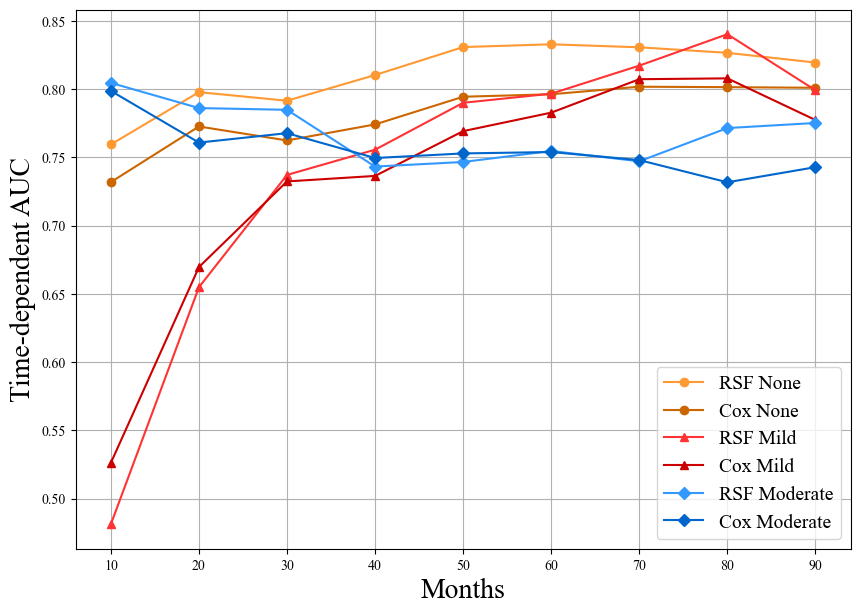

In [62]:
plt.figure(figsize=(10,7))
times = [10, 20, 30, 40, 50, 60, 70, 80, 90]
plt.plot(times, rsf_none, color='#FF9933', label='RSF None', marker='o')
plt.plot(times, cox_none, color='#CC6600', label='Cox None', marker='o')
plt.plot(times, rsf_mild, color='#FF3333', label='RSF Mild', marker='^')
plt.plot(times, cox_mild, color='#CC0000', label='Cox Mild', marker='^')
plt.plot(times, rsf_mode, color='#3399FF', label='RSF Moderate', marker='D')
plt.plot(times, cox_mode, color='#0066CC', label='Cox Moderate', marker='D')
plt.ylabel('Time-dependent AUC', fontsize=20)
plt.xlabel('Months', fontsize=20)
plt.grid(True)
plt.legend(fontsize=14)

# TRP FPR

In [20]:
net_benefit_model,net_benefit_all, _,_ = process_data_rsf(none)

[1.0, 1.0, 0.9925, 0.985, 0.98, 0.9525, 0.94, 0.915, 0.8975, 0.88, 0.86, 0.845, 0.825, 0.805, 0.7825, 0.7625, 0.74, 0.73, 0.7075, 0.6875, 0.6725, 0.665, 0.6425, 0.6275, 0.615, 0.6, 0.5875, 0.5725, 0.5675, 0.555, 0.5525, 0.52, 0.505, 0.49, 0.48, 0.4525, 0.44, 0.4275, 0.4125, 0.4025, 0.39, 0.39, 0.3825, 0.3675, 0.36, 0.35, 0.3375, 0.3225, 0.315, 0.305, 0.2875, 0.28, 0.2625, 0.2525, 0.2375, 0.2175, 0.2, 0.1925, 0.1825, 0.17, 0.1575, 0.1375, 0.1325, 0.115, 0.1025, 0.085, 0.0725, 0.0625, 0.06, 0.0575]
[1.0, 0.955625, 0.868125, 0.789375, 0.699375, 0.6275, 0.57, 0.515625, 0.46375, 0.416875, 0.37625, 0.351875, 0.315625, 0.2875, 0.2675, 0.24875, 0.23, 0.2175, 0.2075, 0.1925, 0.17875, 0.170625, 0.160625, 0.1475, 0.140625, 0.129375, 0.12375, 0.11625, 0.1075, 0.101875, 0.09625, 0.09, 0.085, 0.08375, 0.078125, 0.073125, 0.06875, 0.065625, 0.06375, 0.058125, 0.054375, 0.050625, 0.04625, 0.04375, 0.040625, 0.04, 0.03875, 0.035625, 0.030625, 0.029375, 0.028125, 0.025625, 0.024375, 0.0225, 0.02, 0.0175

In [21]:
none_tpr = [1.0, 1.0, 0.9925, 0.985, 0.98, 0.9525, 0.94, 0.915, 0.8975, 0.88, 0.86, 0.845, 0.825, 0.805, 0.7825, 0.7625, 0.74, 0.73, 0.7075, 0.6875, 0.6725, 0.665, 0.6425, 0.6275, 0.615, 0.6, 0.5875, 0.5725, 0.5675, 0.555, 0.5525, 0.52, 0.505, 0.49, 0.48, 0.4525, 0.44, 0.4275, 0.4125, 0.4025, 0.39, 0.39, 0.3825, 0.3675, 0.36, 0.35, 0.3375, 0.3225, 0.315, 0.305, 0.2875, 0.28, 0.2625, 0.2525, 0.2375, 0.2175, 0.2, 0.1925, 0.1825, 0.17, 0.1575, 0.1375, 0.1325, 0.115, 0.1025, 0.085, 0.0725, 0.0625, 0.06, 0.0575]
none_fpr = [1.0, 0.955625, 0.868125, 0.789375, 0.699375, 0.6275, 0.57, 0.515625, 0.46375, 0.416875, 0.37625, 0.351875, 0.315625, 0.2875, 0.2675, 0.24875, 0.23, 0.2175, 0.2075, 0.1925, 0.17875, 0.170625, 0.160625, 0.1475, 0.140625, 0.129375, 0.12375, 0.11625, 0.1075, 0.101875, 0.09625, 0.09, 0.085, 0.08375, 0.078125, 0.073125, 0.06875, 0.065625, 0.06375, 0.058125, 0.054375, 0.050625, 0.04625, 0.04375, 0.040625, 0.04, 0.03875, 0.035625, 0.030625, 0.029375, 0.028125, 0.025625, 0.024375, 0.0225, 0.02, 0.0175, 0.0175, 0.01625, 0.01625, 0.014375, 0.013125, 0.0125, 0.009375, 0.008125, 0.0075, 0.005625, 0.005, 0.00375, 0.00375, 0.0025]
mild_tpr = [1.0, 0.9900990099009901, 0.9900990099009901, 0.9801980198019802, 0.9801980198019802, 0.9702970297029703, 0.9702970297029703, 0.9504950495049505, 0.9306930693069307, 0.9207920792079208, 0.900990099009901, 0.8811881188118812, 0.8514851485148515, 0.8415841584158416, 0.8415841584158416, 0.8316831683168316, 0.801980198019802, 0.7920792079207921, 0.7821782178217822, 0.7722772277227723, 0.7425742574257426, 0.7425742574257426, 0.7029702970297029, 0.7029702970297029, 0.6633663366336634, 0.6534653465346535, 0.6336633663366337, 0.6237623762376238, 0.6237623762376238, 0.6039603960396039, 0.6039603960396039, 0.5841584158415841, 0.5643564356435643, 0.5544554455445545, 0.5544554455445545, 0.5445544554455446, 0.5346534653465347, 0.504950495049505, 0.504950495049505, 0.504950495049505, 0.504950495049505, 0.4752475247524752, 0.43564356435643564, 0.42574257425742573, 0.40594059405940597, 0.3564356435643564, 0.3465346534653465, 0.32673267326732675, 0.32673267326732675, 0.3069306930693069, 0.27722772277227725, 0.24752475247524752, 0.21782178217821782, 0.2079207920792079, 0.19801980198019803, 0.19801980198019803, 0.18811881188118812, 0.16831683168316833, 0.15841584158415842, 0.13861386138613863, 0.12871287128712872, 0.12871287128712872, 0.12871287128712872, 0.1188118811881188, 0.10891089108910891, 0.0891089108910891, 0.0891089108910891, 0.07920792079207921, 0.06930693069306931, 0.06930693069306931]
mild_fpr = [1.0, 0.9891891891891892, 0.9324324324324325, 0.8837837837837837, 0.8108108108108109, 0.7432432432432432, 0.6783783783783783, 0.6405405405405405, 0.5756756756756757, 0.5378378378378378, 0.5027027027027027, 0.4702702702702703, 0.4486486486486487, 0.4189189189189189, 0.3810810810810811, 0.3567567567567568, 0.34594594594594597, 0.33513513513513515, 0.31351351351351353, 0.3054054054054054, 0.28378378378378377, 0.26756756756756755, 0.24594594594594596, 0.23783783783783785, 0.22162162162162163, 0.21081081081081082, 0.1945945945945946, 0.17297297297297298, 0.16486486486486487, 0.15675675675675677, 0.14324324324324325, 0.13783783783783785, 0.12972972972972974, 0.12702702702702703, 0.12162162162162163, 0.11351351351351352, 0.11081081081081082, 0.10540540540540541, 0.0918918918918919, 0.0891891891891892, 0.08648648648648649, 0.08108108108108109, 0.06756756756756757, 0.06486486486486487, 0.05945945945945946, 0.051351351351351354, 0.04864864864864865, 0.04594594594594595, 0.04594594594594595, 0.04594594594594595, 0.04054054054054054, 0.03783783783783784, 0.03513513513513514, 0.02972972972972973, 0.02972972972972973, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.024324324324324326, 0.024324324324324326, 0.024324324324324326, 0.021621621621621623, 0.021621621621621623, 0.01891891891891892, 0.016216216216216217, 0.013513513513513514, 0.008108108108108109, 0.008108108108108109, 0.008108108108108109, 0.005405405405405406]
mode_tpr = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9833333333333333, 0.9833333333333333, 0.95, 0.9333333333333333, 0.9333333333333333, 0.9, 0.9, 0.8833333333333333, 0.8833333333333333, 0.8666666666666667, 0.8333333333333334, 0.8166666666666667, 0.7833333333333333, 0.7333333333333333, 0.7166666666666667, 0.6833333333333333, 0.6666666666666666, 0.6666666666666666, 0.6333333333333333, 0.6, 0.5666666666666667, 0.5333333333333333, 0.5166666666666667, 0.48333333333333334, 0.48333333333333334, 0.4666666666666667, 0.4666666666666667, 0.4666666666666667, 0.4666666666666667, 0.45, 0.43333333333333335, 0.4, 0.36666666666666664, 0.36666666666666664, 0.3333333333333333, 0.31666666666666665, 0.31666666666666665, 0.2833333333333333, 0.26666666666666666, 0.25, 0.25, 0.23333333333333334, 0.21666666666666667, 0.21666666666666667, 0.21666666666666667, 0.21666666666666667, 0.21666666666666667, 0.21666666666666667, 0.2, 0.18333333333333332, 0.15, 0.13333333333333333, 0.11666666666666667, 0.11666666666666667, 0.1, 0.1, 0.1, 0.1, 0.1, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.06666666666666667]
mode_fpr = [1.0, 0.996031746031746, 0.9920634920634921, 0.9761904761904762, 0.9484126984126984, 0.9206349206349206, 0.8611111111111112, 0.8055555555555556, 0.75, 0.7142857142857143, 0.6746031746031746, 0.6468253968253969, 0.6031746031746031, 0.5674603174603174, 0.5277777777777778, 0.49603174603174605, 0.4603174603174603, 0.4166666666666667, 0.4007936507936508, 0.3968253968253968, 0.36904761904761907, 0.32142857142857145, 0.3055555555555556, 0.29365079365079366, 0.2857142857142857, 0.2698412698412698, 0.25793650793650796, 0.24206349206349206, 0.23412698412698413, 0.2222222222222222, 0.21031746031746032, 0.19444444444444445, 0.16666666666666666, 0.15476190476190477, 0.14285714285714285, 0.1349206349206349, 0.1111111111111111, 0.10714285714285714, 0.0992063492063492, 0.09126984126984126, 0.0873015873015873, 0.08333333333333333, 0.07539682539682539, 0.07142857142857142, 0.06746031746031746, 0.06746031746031746, 0.05555555555555555, 0.05555555555555555, 0.05555555555555555, 0.04365079365079365, 0.03968253968253968, 0.03968253968253968, 0.03571428571428571, 0.031746031746031744, 0.027777777777777776, 0.027777777777777776, 0.023809523809523808, 0.023809523809523808, 0.023809523809523808, 0.023809523809523808, 0.01984126984126984, 0.01984126984126984, 0.01984126984126984, 0.015873015873015872, 0.011904761904761904, 0.011904761904761904, 0.007936507936507936, 0.003968253968253968, 0.003968253968253968, 0.003968253968253968]

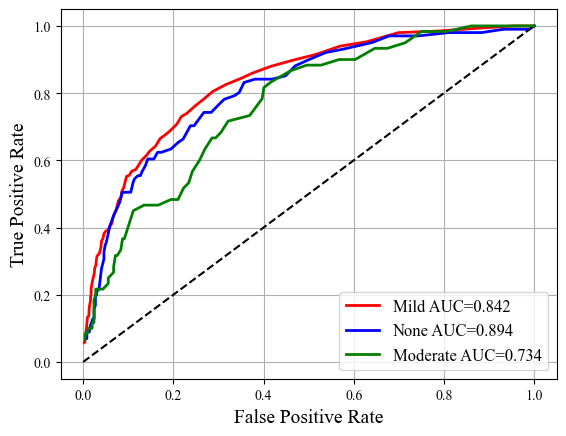

In [63]:
plt.figure()
lw = 2
plt.plot(none_fpr, none_tpr, color='red', lw=lw, label=f"Mild AUC=0.842")
plt.plot(mild_fpr, mild_tpr, color='blue', lw=lw, label=f"None AUC=0.894")
plt.plot(mode_fpr, mode_tpr, color='green', lw=lw, label=f"Moderate AUC=0.734")
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)